## Summary of VAC files

* `thejoker-samples.hdf5`: This file contains the output rom The Joker samplings. The keys in the file are the `APOGEE_ID` values. Under each key are datasets that contain the sample values, e.g., `P` for period, `e` for eccentricity, etc., along with the log-likelihood and log-prior values of each sample.
* `thejoker-metadata.fits`: This file contains summary information and metadata about The Joker samplings in `thejoker-samples.hdf5`. For example, this contains the maximum a posteriori (MAP) sample values, and some computed statistics (like phase-coverage).
* `emcee-metadata.fits`: This file contains summary information from running `emcee` to generate standard MCMC samplings for sources that return unimodal samplings from The Joker. 
* `constant-fit.fits `: This file contains the maximum likelihood values from fitting a constant velocity model to each source's visit RV data.

In [4]:
from os import path
import os

import astropy.coordinates as coord
from astropy.constants import G
from astropy.table import Table, QTable, join
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

from hq.config import config_to_jokerparams
from hq.plot import plot_two_panel, plot_phase_fold
from hq.data import get_rvdata

from thejoker.plot import plot_rv_curves
from thejoker import JokerSamples, JokerParams, TheJoker

from twobody.transforms import get_m2_min

Modify this to point to the path where you downloaded the VAC data products:

In [5]:
data_path = path.abspath('../cache/dr16-beta-demo/')
poly_trend = 1 #a config setting from the run - keep this set to 1

Load the allStar and allVisit files for DR16 beta - again, you might need to modify this to point to the location where you downloaded the DR16 beta files:

In [6]:
allstar = Table.read('../data/allStar-r12-l33beta.fits')
allvisit = Table.read('../data/allVisit-r12-l33beta.fits')

Load the metadata tables and join to the results from fitting the constant velocity model to the visit RV data:

In [7]:
meta = QTable.read(path.join(data_path, 'thejoker-metadata.fits'))

const = Table.read(path.join(data_path, 'constant-fit.fits'))
meta = join(meta, const, keys='APOGEE_ID')

# Retrieve only unique APOGEE_IDs from the metadata file:
_, idx = np.unique(meta['APOGEE_ID'], return_index=True)
meta = meta[idx]
len(meta)

224403

The metadata table now contains a number of columns that might be useful to filtering out interesting systems. 

### Data model: thejoker-metadata.fits

The first column in the `meta` table is the APOGEE_ID of each source. 

The next several columns are the maximum a posteriori (MAP) values of the Keplerian orbital parameters for each source. For very unconstrained orbital parameters, these values aren't too useful, but for sources with many visits this is a good initial guess for the true orbital parameter values.

Mixed in the above is the log-likelihood, `ln_likelihood`, value compued for the MAP sample, `MAP_ln_likelihood`.

Next is a boolean column, `joker_completed`, that specifies whether the sampling with The Joker returned the number of samples we requested (256): If The Joker returned 256 samples, then a source is considered "completed" by The Joker and it has a `True` value in this column. More on this later.

The next few columns are statistics computed from the MAP sample value:
- `max_phase_gap` folds the visit RV curve on the MAP period and computes the largest gap in phase coverage
- `periods_spanned` is the number of MAP periods spanned (end to end) for the visits
- `phase_coverage` is computed by binning the phase values of the data, folded on the MAP period, i.e., the number of bins with >= 1 data point (bin width = 0.1 in phase).

`n_visits` is the number of visits for a given source that passed the quality cuts used for this catalog.

`unimodal` indicates whether the sampling returned by The Joker is unimodal in period or not. If this column is `True`, standard MCMC (with `emcee`) was then run to improve the orbital parameter samplings and you should use the emcee metadata file instead - more on that soon.

The last few columns -- `constant_ln_likelihood`, `robust_constant_ln_likelihood` -- contain the maximum likelihood values from fitting a constant RV model, and a robust (i.e., with an outlier model) constant RV model to the data. This column can be used with `MAP_ln_likelihood` as a way to select out probable binaries, i.e., by doing a likelihood ratio cut. More on that below.

Other columns can be ignored.

In [8]:
meta

APOGEE_ID,MAP_K,MAP_M0,MAP_P,MAP_e,MAP_jitter,MAP_ln_likelihood,MAP_ln_prior,MAP_omega,MAP_v0,joker_completed,max_phase_gap,max_unmarginalized_ln_likelihood,n_visits,periods_spanned,phase_coverage,t0_bmjd,unimodal,constant_ln_likelihood,robust_constant_ln_likelihood,robust_success
,km / s,rad,d,,km / s,,,rad,km / s,,,,,,,,,,,
bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,int64,float64,float64,float64,bool,float64,float64,bool
2M00000002+7417074,0.03973023903597637,1.4411753416061401,2.2188427448272705,0.0018884656019508839,0.0,4.688860783383183,-5.064410209655762,4.681254061060496,-51.666218359503745,True,0.2260112268881087,2.5779581716253954,3,17.126044953557532,0.3,56933.26435137996,False,1.9817557642831514,1.898155896408913,False
2M00000068+5710233,0.14423472492088785,0.09303409606218338,2.0808916091918945,0.024079572409391403,0.0,5.127602820151967,-5.384428024291992,6.142990589141846,-12.516720153512324,True,0.2775028739325194,2.5442512099433534,3,373.27750287392206,0.3,55874.17793338723,False,2.522416227411188,2.5215361358975104,False
2M00000222+5625359,9.763042372206685,1.1086117029190063,3.442991018295288,0.052109718322753906,0.0,4.87367908293782,-6.049805164337158,0.891664830846242,-45.26735715474349,True,0.3897931255819831,2.36996128702815,3,6.68023826756523,0.3,55821.30330256523,False,-2783.4409677519084,-12.419623021705993,True
2M00000233+1452324,0.05543549616060406,4.049540042877197,3.8375632762908936,0.00626798253506422,0.0,5.2783814868960395,-5.780747413635254,4.008700370788574,-38.93029167571497,True,0.5145506645339986,2.5438657135426186,3,7.556878770751898,0.2,56584.25006596872,False,1.7164897598459814,1.6201881658357888,True
2M00000446+5854329,0.35770542140534967,3.4293324947357178,2.834360122680664,0.00418725935742259,0.0,4.689171899326431,-5.419826984405518,2.987565279006958,-48.00106207954139,True,0.41125329525342913,2.2804193346906354,3,9.525959743420149,0.3,56257.11355090288,False,2.163573072842849,2.0201084765534505,True
2M00000535+1504343,0.19922063238962623,3.7052268981933594,2.448208808898926,0.0072797974571585655,0.0,4.871473149506181,-5.353237628936768,2.8544157425588885,18.58011005106259,True,0.6338475900514466,2.478474596017725,3,11.84539502864644,0.3,56584.25006596872,False,2.460858586657567,2.4103195279477108,False
2M00000546+6152107,0.10546174222429787,4.987072944641113,2.1260480880737305,0.023455848917365074,0.0,5.202186559625857,-5.401109218597412,3.071702241897583,-33.265922501188435,True,0.5404888457254611,2.5660917303291066,3,25.281648681152305,0.3,56938.23962145692,False,2.5134511729946785,2.5133132704660284,False
2M00000797+6436119,0.49522628324499285,4.527565956115723,3.9969661235809326,0.014488941989839077,0.0,5.1717136734721585,-5.949754238128662,1.0177360773086548,-120.28936171074078,True,0.2539850676235895,2.780714479021564,4,11.696371520139278,0.4,56590.227496061925,False,-11.027793259556057,-3.6973422829048084,True


We can now join the metadata table with the allstar table to have access to the APOGEE data along side The Joker sampling information:

In [9]:
# allStar table and 
meta = join(meta, allstar, keys='APOGEE_ID')

To select out probably binaries or multiple systems, we can make a cut on the log-likelihood ratio of comparing The Joker samplings to the robust constant model fit to the data. First, we compute the log-likelihood ratio (`llr`):

In [10]:
llr = meta['max_unmarginalized_ln_likelihood'] - meta['robust_constant_ln_likelihood']

Let's look at a histogram of the `llr` values:

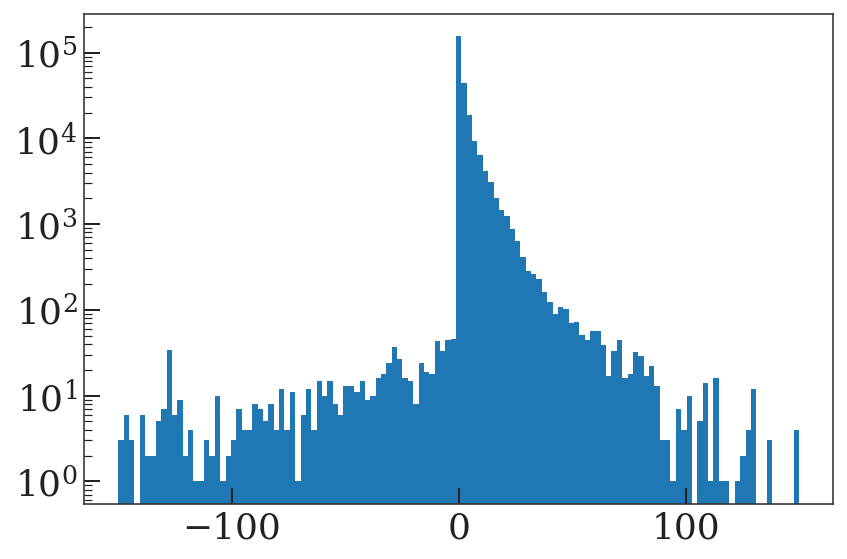

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bins = np.linspace(-150, 150, 128)
ax.hist(llr, bins=bins)
ax.set_yscale('log')
fig.tight_layout()

We'll now make a conservative cut on the `llr` to select probably binary systems (this cut is arbitrary! I found that going down to ~8 or so still looks pretty good, but for now let's be conservative and require a really large likelihood ratio):

In [12]:
binary_mask = llr > 16
binary_mask.sum()

8140

That still returns ~8000 systems!

Let's look at the RV curves and samples for a few of these systems:

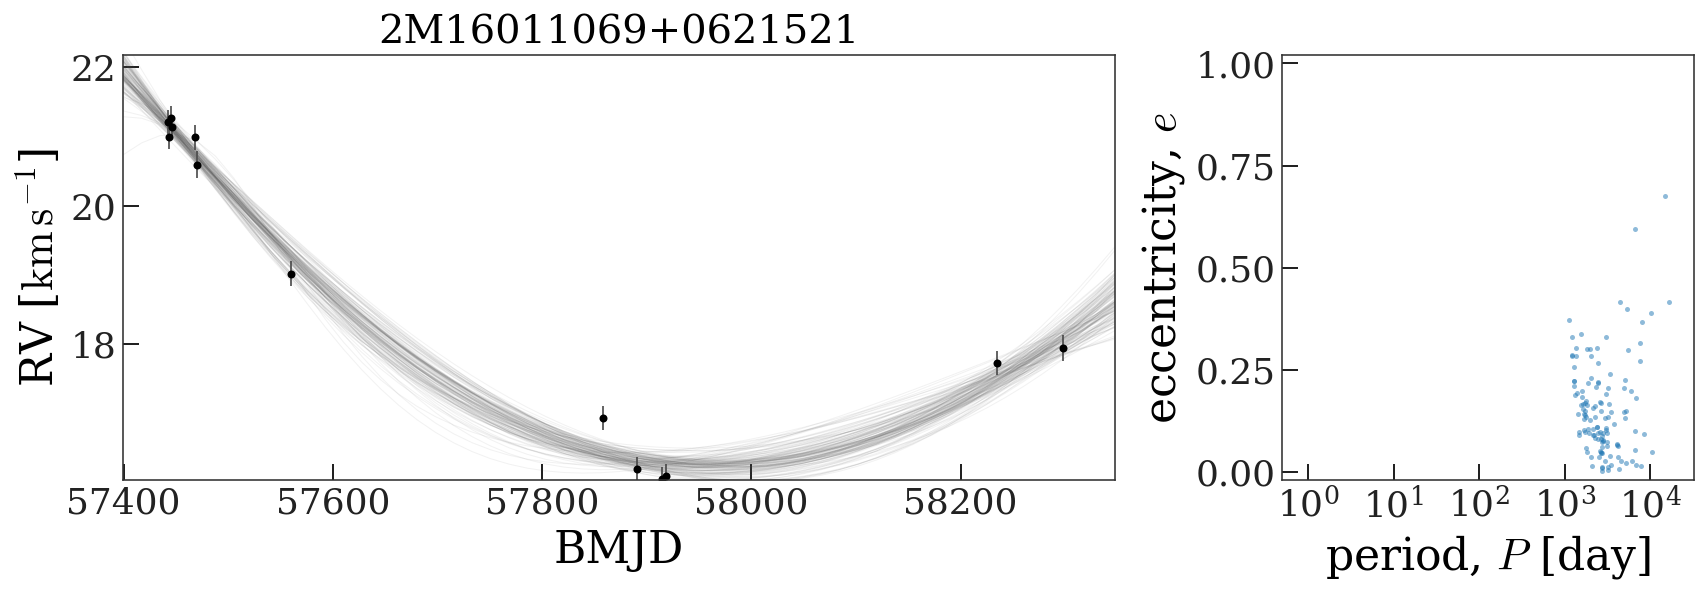

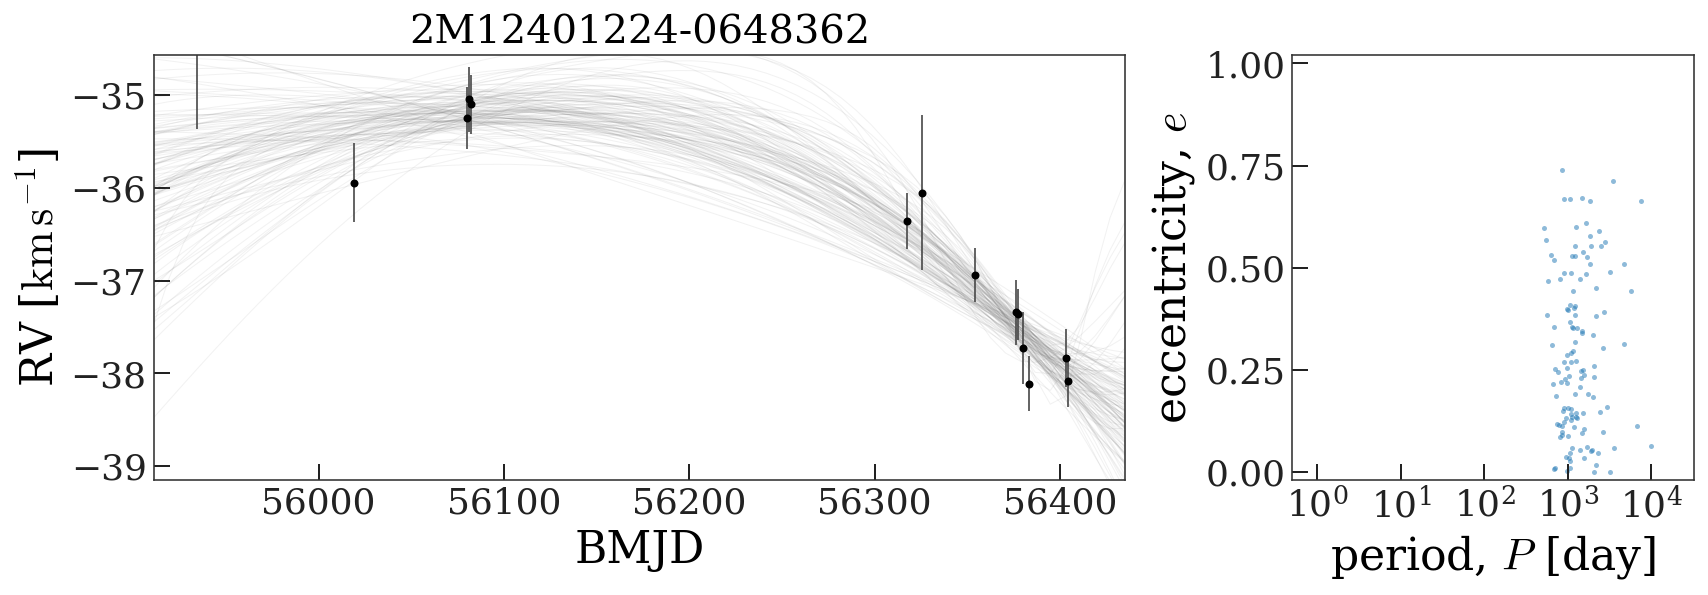

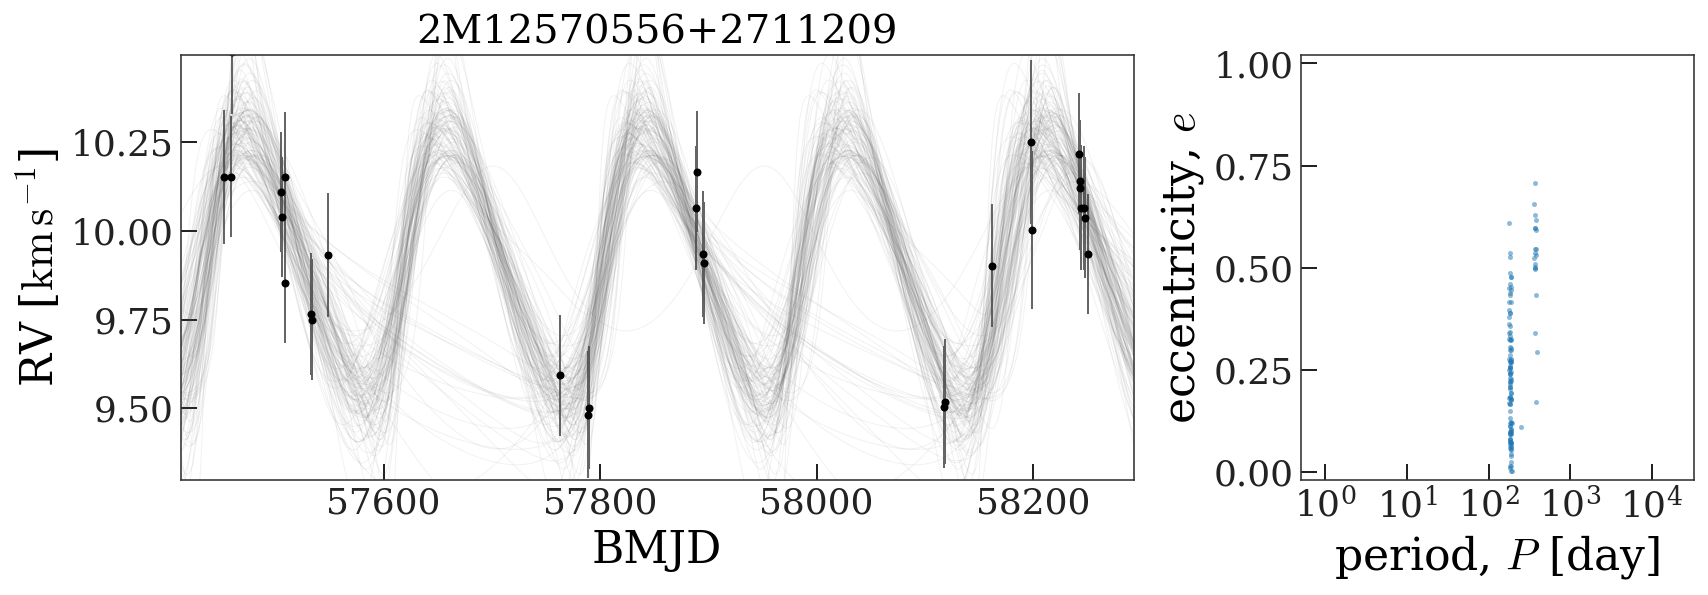

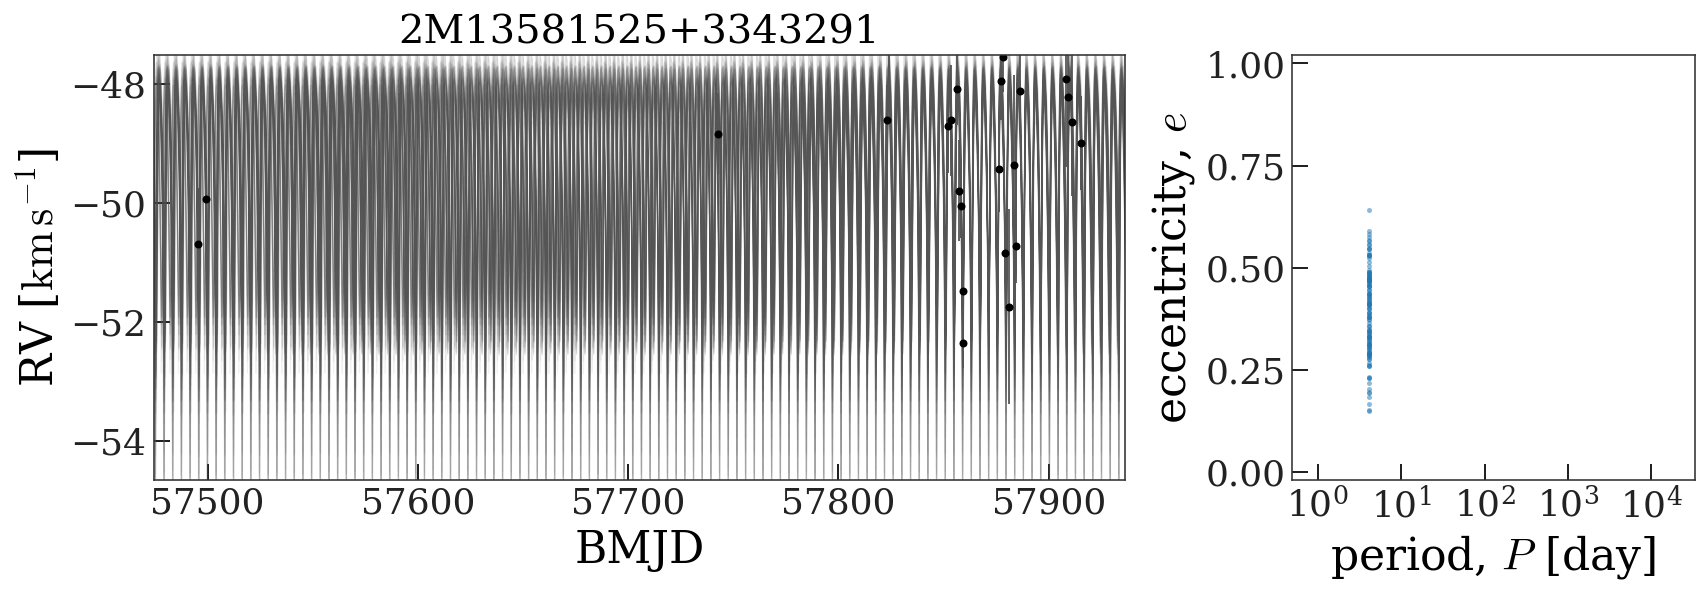

In [14]:
with h5py.File(path.join(data_path, 'thejoker-samples.hdf5'), 'r') as results_f:
    for i in np.random.choice(np.where(binary_mask)[0], size=4, replace=False):
        star = meta[i]
        samples = JokerSamples.from_hdf5(results_f[star['APOGEE_ID']], 
                                         poly_trend=poly_trend)
    
        _visits = allvisit[allvisit['APOGEE_ID'] == star['APOGEE_ID']]
        data = get_rvdata(_visits)
        fig = plot_two_panel(data, samples[:128], title='{}'.format(star['APOGEE_ID']))
        fig.tight_layout()

### Data model: emcee-metadata.fits

This file is similar to the summary file `thejoker-metadata.fits`, but contains summary information from running `emcee` to complete the posterior samplings for all sources that end up with unimodal period distributions from running The Joker. The MAP orbital parameter estimates from the `emcee` runs are included in the table with names that end with `_emcee`, and each parameter also has an estimate of the uncertainty on the MAP parameter with column names that end in `_err`. This file also contains an estimate of the median Gelman-Rubin statistic, `R_med`, which provides a way to select out converged MCMC samplings (`R_med < 1.1`). We also compute the phase coverage statistics from the MAP emcee sample (e.g., `phase_coverage_emcee`, `periods_spanned_emcee`).

In [18]:
meta_emcee = QTable.read(path.join(data_path, 'emcee-metadata.fits'))
meta_emcee = join(meta_emcee, meta, keys='APOGEE_ID', table_names=['emcee', 'joker'])
_, idx = np.unique(meta_emcee['APOGEE_ID'], return_index=True)
meta_emcee = meta_emcee[idx]
llr_emcee = meta_emcee['max_unmarginalized_ln_likelihood_emcee'] - meta_emcee['robust_constant_ln_likelihood']

In [19]:
meta_emcee.colnames

['APOGEE_ID',
 'MAP_K_emcee',
 'MAP_K_err',
 'MAP_M0_emcee',
 'MAP_M0_err',
 'MAP_P_emcee',
 'MAP_P_err',
 'MAP_e_emcee',
 'MAP_e_err',
 'MAP_jitter_emcee',
 'MAP_jitter_err',
 'MAP_omega_emcee',
 'MAP_omega_err',
 'MAP_v0_emcee',
 'MAP_v0_err',
 'R_max',
 'R_med',
 'max_phase_gap_emcee',
 'max_unmarginalized_ln_likelihood_emcee',
 'n_visits_emcee',
 'periods_spanned_emcee',
 'phase_coverage_emcee',
 'phase_coverage_per_period',
 't0_bmjd_emcee',
 'MAP_K_joker',
 'MAP_M0_joker',
 'MAP_P_joker',
 'MAP_e_joker',
 'MAP_jitter_joker',
 'MAP_ln_likelihood',
 'MAP_ln_prior',
 'MAP_omega_joker',
 'MAP_v0_joker',
 'joker_completed',
 'max_phase_gap_joker',
 'max_unmarginalized_ln_likelihood_joker',
 'n_visits_joker',
 'periods_spanned_joker',
 'phase_coverage_joker',
 't0_bmjd_joker',
 'unimodal',
 'constant_ln_likelihood',
 'robust_constant_ln_likelihood',
 'robust_success',
 'APSTAR_ID',
 'TARGET_ID',
 'ASPCAP_ID',
 'FILE',
 'TELESCOPE',
 'LOCATION_ID',
 'FIELD',
 'J',
 'J_ERR',
 'H',
 'H_ER

We can compute the same log-likelihood ratio from the MCMC runs as before to select out confident binary systems that have unimodal / well-determined orbital properties. Again, making a very conservative cut:

In [20]:
(llr_emcee > 16).sum()

591

Let's now pick a subset with good phase coverage:

In [21]:
subset = meta_emcee[(llr_emcee > 16) & 
                    (meta_emcee['phase_coverage_per_period'] >= 4) &
                    (meta_emcee['phase_coverage_emcee'] > 0.8) & 
                    (meta_emcee['max_unmarginalized_ln_likelihood_emcee'] > -10)]
len(subset)

29

And plot a few of these systems:

INFO: Filtering 1 NaN/Inf data points [thejoker.data]
INFO: Filtering 1 NaN/Inf data points [thejoker.data]


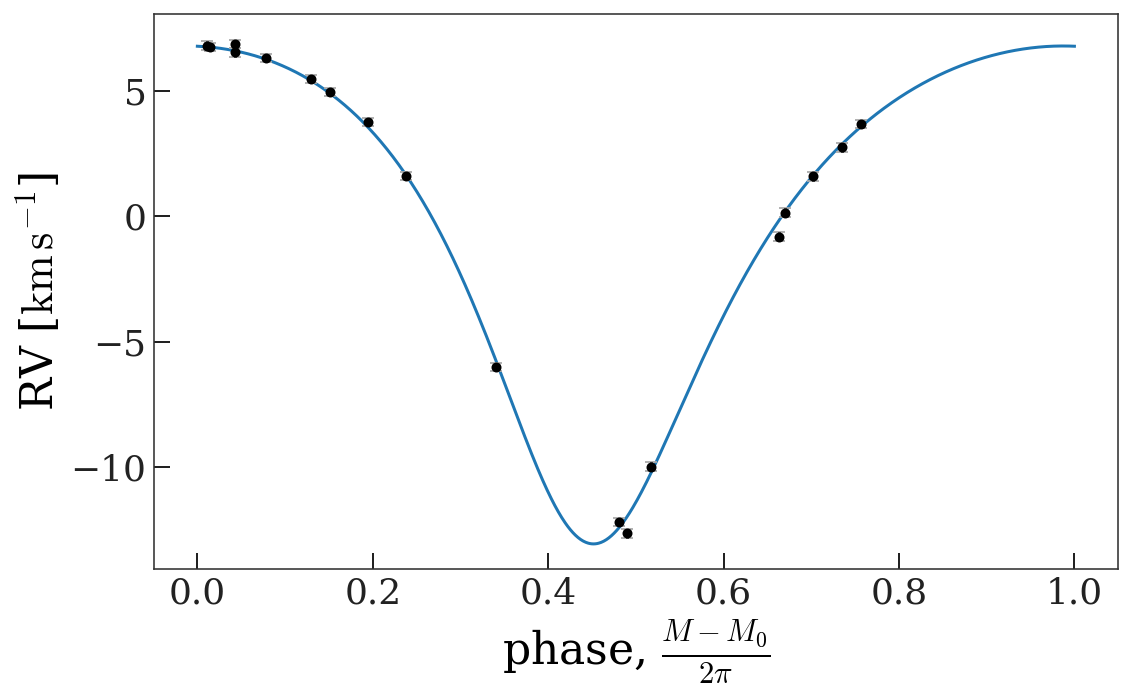

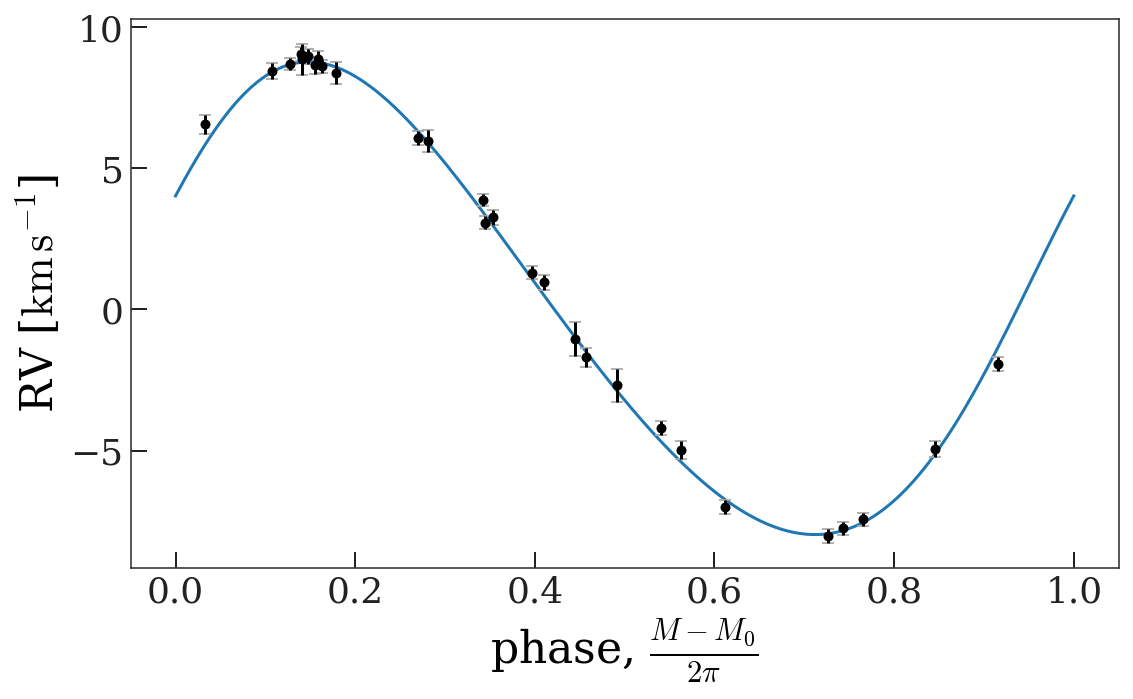

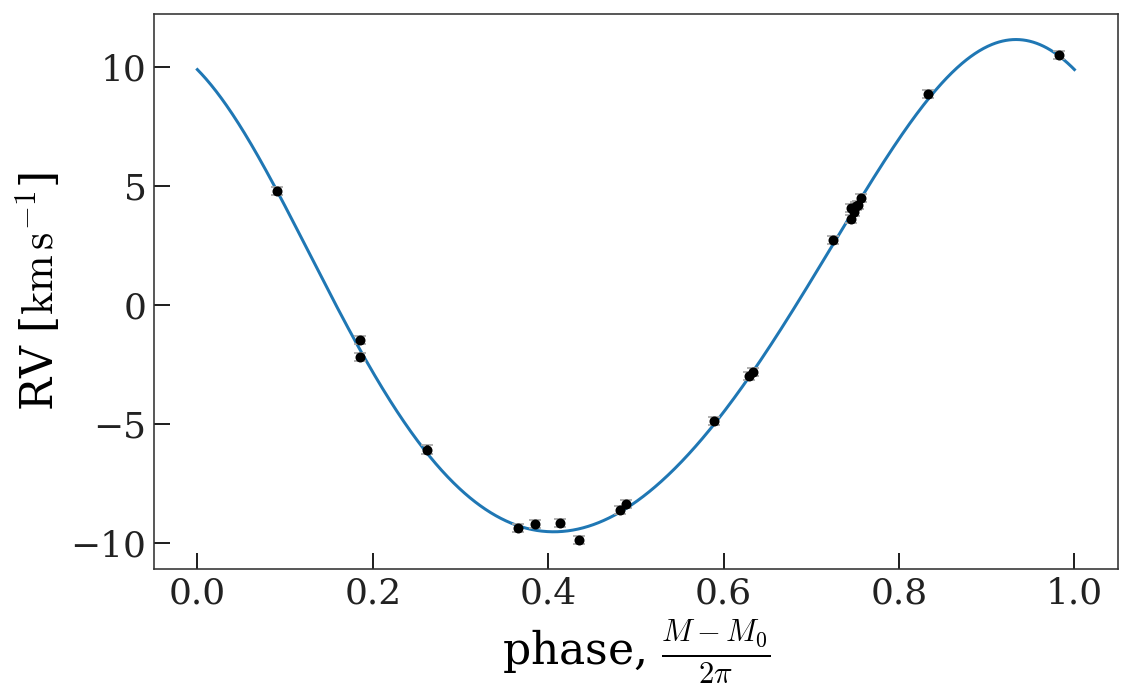

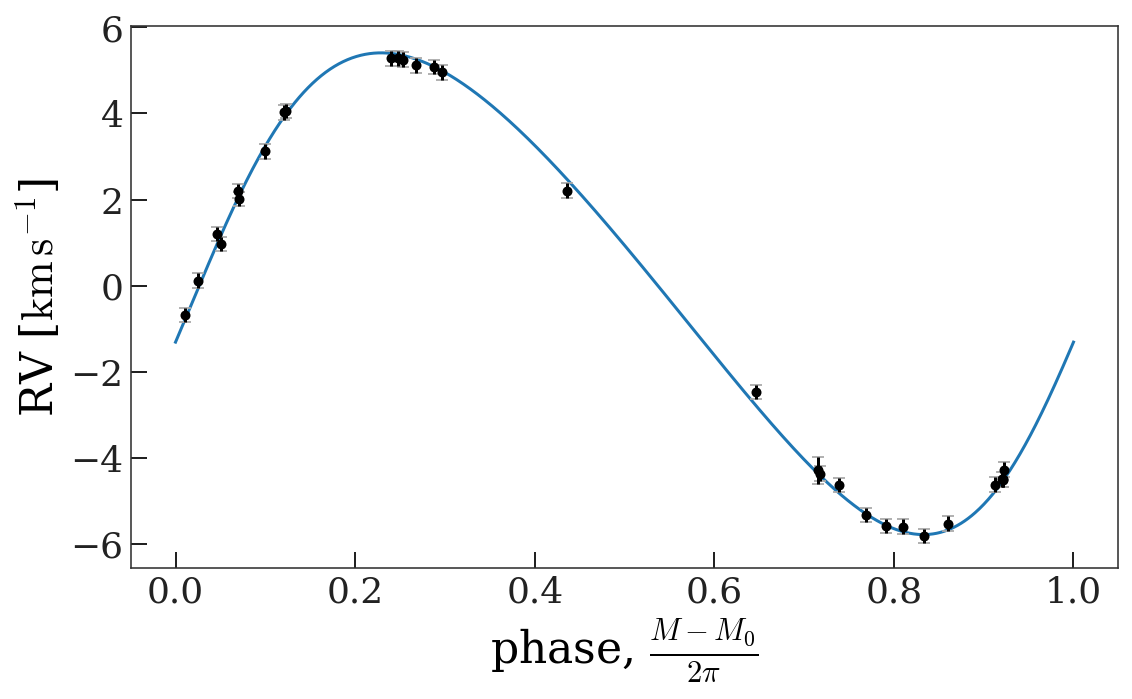

In [53]:
with h5py.File(path.join(data_path, 'thejoker-samples.hdf5'), 'r') as results_f:
    for star in subset[:4]:
        samples = JokerSamples.from_hdf5(results_f[star['APOGEE_ID']], 
                                         poly_trend=poly_trend)
    
        _visits = allvisit[allvisit['APOGEE_ID'] == star['APOGEE_ID']]
        data = get_rvdata(_visits)
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        fig = plot_phase_fold(data, samples[0], ax=ax)
        fig.tight_layout()

Please let Adrian (adrianmpw@gmail.com) know if you encounter any surprises or issues, or have requests / suggestions.